https://www.gdeltproject.org/data/lookups/FIPS.country.txt

In [1022]:
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf



from scipy import stats

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')


In [1194]:
class HumanitarianCrisisModel:
    
    def __init__(self, country_code, frequency='d', forecast_column='HumanitarianCrisisProportions', event_count=10000):
        self.country_code = country_code
        self.frequency = frequency
        self.event_count = event_count
        self.forecast_column = forecast_column
        self.query_job = self.run_query()
        self.country_df = self.convert_query_to_df()
        self.labeled_df = self.label_df()
        self.clean_df = self.clean_df()
        self.humanitarian_crisis_ts = self.group_df()
        self.country_name = self.get_country_name()
        self.residual = self.get_residual()
        self.best_order = self.run_auto_arima()[1]
        self.arima_model = self.run_best_ARIMA_model()[0]
        
        
        
    def run_query(self):
                
        credentials = service_account.Credentials.from_service_account_file(
            '../keys/graphic-charter-320020-b542ced38875.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
        )

        client = bigquery.Client(credentials=credentials, project=credentials.project_id)

        query = f"""
        SELECT SQLDATE, EventCode
        FROM `gdelt-bq.gdeltv2.events` 
        WHERE ActionGeo_CountryCode = @country
        AND SQLDATE > 20160101
        ORDER BY SQLDATE DESC
        LIMIT @event_count
        """

        # parameterized query that extract event rows from the GDELT dataset in BigQuery
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("country", "STRING", self.country_code),
                bigquery.ScalarQueryParameter("event_count", "INT64", self.event_count),

            ]
        )
        query_job = client.query(query, job_config=job_config) 
        
        return query_job
    
    def convert_query_to_df(self):
        
        # converts the query into a dataframe
        country_df = self.query_job.to_dataframe()
        
        return country_df
    
    def label_df(self):
        # determines which events should be labeled as humanitarian crisis events
        humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                                  '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                                  '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                                  '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                                  '1833', '184']

        self.country_df['IsHumanitarianCrisis'] = self.country_df.EventCode.isin(humanitarian_crisis_events)
        labeled_df  = self.country_df
        return labeled_df
    
    
    
    def clean_df(self):

        # Structure the dataframe; set the event date as the index
        self.labeled_df.SQLDATE = pd.to_datetime(self.labeled_df.SQLDATE, format='%Y%m%d', errors='ignore')
        self.labeled_df = self.labeled_df.set_index('SQLDATE')
        clean_df = self.labeled_df
        
        return clean_df
    
    def group_df(self):

        # Group the events by the given frequency
        country_df_grouped = self.clean_df['IsHumanitarianCrisis'].groupby(pd.Grouper(freq=self.frequency)).agg(['sum','count','mean'])
        country_df_grouped.columns = ['HumanitarianCrisisEvents', 'TotalEvents', 'HumanitarianCrisisProportions']
        humanitarian_crisis_ts = country_df_grouped[self.forecast_column].dropna()
#         humanitarian_crisis_ts = humanitarian_crisis_ts[humanitarian_crisis_ts.index > '2016-01-01']
        
        return humanitarian_crisis_ts
    
    def get_country_name(self):

        # Lookup the name of the given country code
        lookup_df = pd.read_csv('../data/country_code_lookup.csv')
        country_name = lookup_df[lookup_df['Country Code'] == self.country_code].Country.values[0]
        
        return country_name

    def plot_original_data(self):
        # plot the original data
        plt.figure(figsize=(14, 4))
        plt.figtext(.5,.9,f'Humanitarian Crisis in {self.country_name}\n', fontsize=20, ha='center')
        plt.plot(self.humanitarian_crisis_ts, color='#D2042D') 
        plt.ylabel(f'new');
        
        
    def stationarity_test(self, ts, window=30, title='Stationarity Test'):
        # performn a Dickey-Full Test on the Time Series 
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(ts, autolag = 'AIC')

        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
        for k, v in dftest[4].items():
            dfoutput[f'Critiical Values: {k}'] = v

        print(dfoutput)

        rollmean = ts.rolling(window=window).mean()
        rollstd = ts.rolling(window=window).std()
        
        # plot the Time Series data against the rolling mean and the std to visualize stationarity
        plt.figure(figsize=(14, 4))
        original = plt.plot(ts, color = '#D2042D', label = 'Original')
        mean = plt.plot(rollmean, color = '#0092F4', label = 'Rolling Mean')
        std = plt.plot(rollstd, color = '#99d3fb', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.figtext(.5,.9,f'{title}\n', fontsize=20, ha='center')
        
        
    def decompose_ts(self):
        
        decomposition = seasonal_decompose(self.humanitarian_crisis_ts, period=1)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        
        # plot the trend and seasonality of data using seasonal decompose method from statsmodels
        plt.figure(figsize=(14,12))
        plt.subplot(411)
        plt.plot(self.humanitarian_crisis_ts, label = 'Original', color = '#D2042D')
        plt.legend()
        plt.subplot(412)
        plt.plot(trend, label = 'Trend', color = '#99d3fb')
        plt.legend()
        plt.subplot(413)
        plt.plot(seasonal, label = 'Seasonal', color = '#0092F4')
        plt.legend()
        plt.subplot(414)
        plt.plot(self.residual, label = 'Residual', color = '#003a62')
        plt.legend(loc='upper right')
        
    def get_residual(self):
        decomposition = seasonal_decompose(self.humanitarian_crisis_ts, period=1)
        residual = decomposition.resid
        residual.dropna(inplace=True)

        return residual

            
        
    def plot_residual(self):
        
        (mu, sigma) = stats.norm.fit(self.residual)
        
        plt.figure(figsize=(10,6))
        plt.hist(self.residual, color='#003a62')
        plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
        plt.ylabel('Frequency')
        plt.figtext(.5,.9,f'Residual distribution\n', fontsize=20, ha='center')
        
    def run_auto_arima(self):
        
        stepwise_fit = auto_arima(self.humanitarian_crisis_ts, trace=False, suppress_warnings=True)
        stepwise_fit.summary()
        
        return stepwise_fit.summary(), stepwise_fit.order
    
    def plot_pacf_acf(self):
    
        lag_pacf = pacf(self.humanitarian_crisis_ts, method='ols', nlags = 10 )
        lag_acf = acf(self.humanitarian_crisis_ts, nlags = 10)


        plt.figure(figsize=(8,8))
        plt.subplot(211)
        plt.plot(lag_pacf, color='#0075c3')
        plt.axhline(y=0, linestyle='--', color='grey')
        plt.axhline(y=-1.96/np.sqrt(len(self.humanitarian_crisis_ts)), linestyle='--', color='grey')
        plt.axhline(y=1.96/np.sqrt(len(self.humanitarian_crisis_ts)), linestyle='--', color='grey')
        plt.title('Partial Autocorrelation Function')


        plt.subplot(212)
        plt.plot(lag_acf, color='#0066ab')
        plt.axhline(y=0, linestyle='--', color='grey')
        plt.axhline(y=-1.96/np.sqrt(len(self.humanitarian_crisis_ts)), linestyle='--', color='grey')
        plt.axhline(y=1.96/np.sqrt(len(self.humanitarian_crisis_ts)), linestyle='--', color='grey')
        plt.title('Autocorrelation Function')
        ;
    

    def run_best_ARIMA_model(self, order=None):
        
        if order is None:
            model = ARIMA(self.humanitarian_crisis_ts, order=self.best_order)   
        else:
            model = ARIMA(self.humanitarian_crisis_ts, order=order)
        model = model.fit()
        model.summary()
        return model, model.summary()
    
    def predict(self, end_frequency=30):
        end=len(self.humanitarian_crisis_ts)
        
        pred = self.arima_model.predict(start=1, end=end+end_frequency)
        if pred.index[0] in [0,1]:
            pred = self.arima_model.predict()
                
        plt.figure(figsize=(14,4))
        plt.plot(self.humanitarian_crisis_ts, color='#D2042D', label='original')
        plt.plot(np.abs(pred), color='#0092F4', label='forecasted')
        plt.figtext(.5,.9,f'Humanitarian Crisis Forecast on {self.country_name}\n', fontsize=20, ha='center')
        plt.legend()
        
    def predict_with_ci(self, end_frequency=30):
        
        fig, ax = plt.subplots(figsize=(14,4))
        
        end=len(self.humanitarian_crisis_ts)
        pred = self.arima_model.predict(start=1, end=end+end_frequency)
        
        if pred.index[0] in [0,1]:
            self.arima_model.plot_predict(ax=ax)
        else:
            self.arima_model.plot_predict(end=end+end_frequency, ax=ax)
           
        plt.gca().get_lines()[1].set_color('#f6cdd5')        
        plt.figtext(.5,.9,f'Humanitarian Crisis Forecast on {self.country_name}\n', fontsize=20, ha='center')

        
        
        



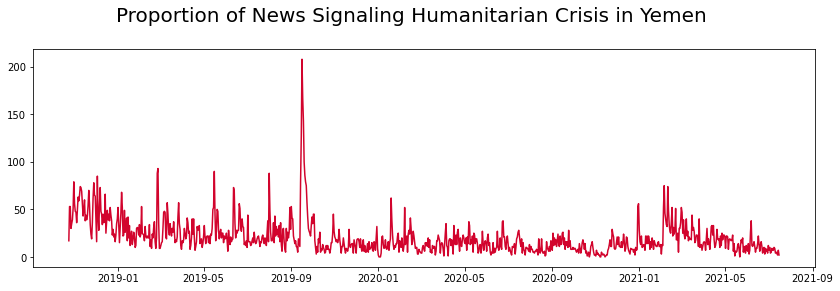

In [1184]:
new_model  = HumanitarianCrisisModel(country_code='YM', frequency='d', event_count=500000)
new_model.plot_original_data()

Results of Dickey-Fuller Test:
Test Statistic            -4.534520
p-value                    0.000170
# Lags Used               13.000000
# of Obs Used            983.000000
Critiical Values: 1%      -3.437020
Critiical Values: 5%      -2.864485
Critiical Values: 10%     -2.568338
dtype: float64


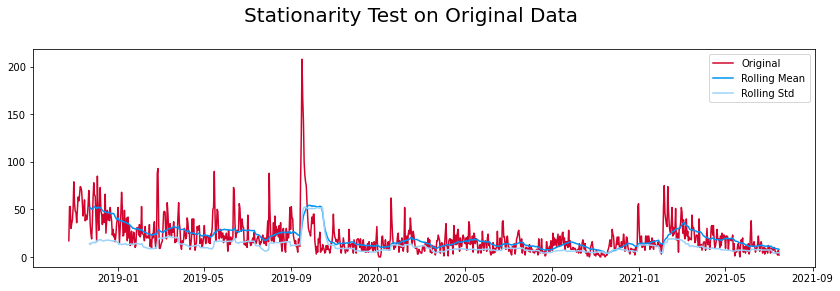

In [1185]:
ts = new_model.humanitarian_crisis_ts
new_model.stationarity_test(ts=ts, window=30, title='Stationarity Test on Original Data')


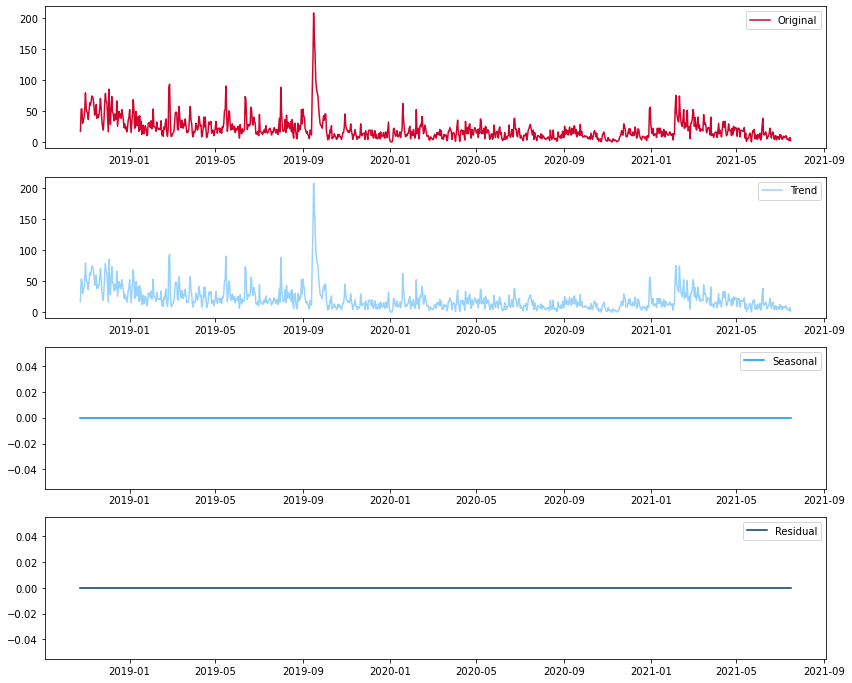

In [1187]:
new_model.decompose_ts()

Results of Dickey-Fuller Test:
Test Statistic                  NaN
p-value                         NaN
# Lags Used                0.000000
# of Obs Used            996.000000
Critiical Values: 1%      -3.436933
Critiical Values: 5%      -2.864446
Critiical Values: 10%     -2.568317
dtype: float64


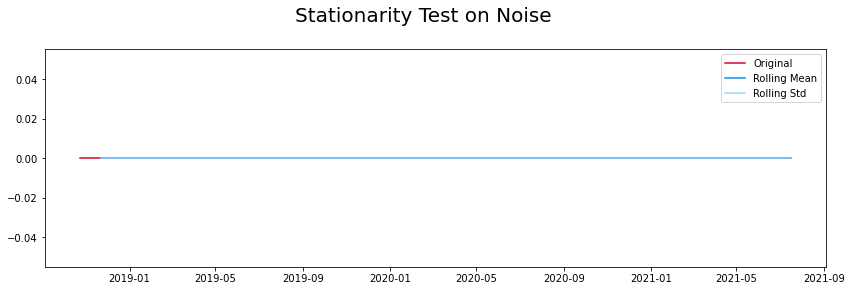

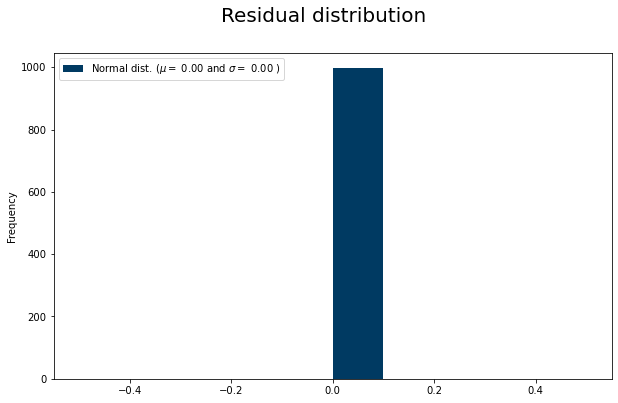

In [1188]:
resid = new_model.residual
new_model.stationarity_test(ts=resid, window=30, title='Stationarity Test on Noise')
new_model.plot_residual()

In [1189]:
new_model.run_auto_arima()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                      y   No. Observations:                  997
 Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3868.171
 Date:                Fri, 16 Jul 2021   AIC                           7742.343
 Time:                        16:18:49   BIC                           7757.054
 Sample:                             0   HQIC                          7747.935
                                 - 997                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          0.6389      0.017     37.629      0.000       0.606       0.672
 ma.L1         -0.9660      0.010    -94.313      0.000      -0.986   

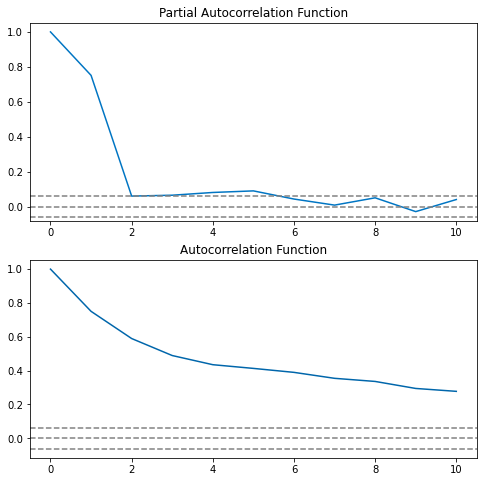

In [1190]:
new_model.plot_pacf_acf()

In [1191]:
new_model.run_best_ARIMA_model()

(<statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x7fbf62f1bad0>,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                  ARIMA Model Results                                  
 Dep. Variable:     D.HumanitarianCrisisEvents   No. Observations:                  996
 Model:                         ARIMA(1, 1, 1)   Log Likelihood               -3867.576
 Method:                               css-mle   S.D. of innovations             11.745
 Date:                        Fri, 16 Jul 2021   AIC                           7743.153
 Time:                                16:18:58   BIC                           7762.768
 Sample:                            10-25-2018   HQIC                          7750.609
                                  - 07-16-2021                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------------------

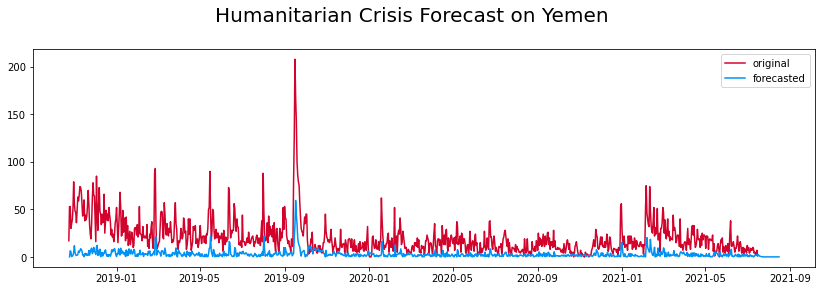

In [1192]:
new_model.predict(30)

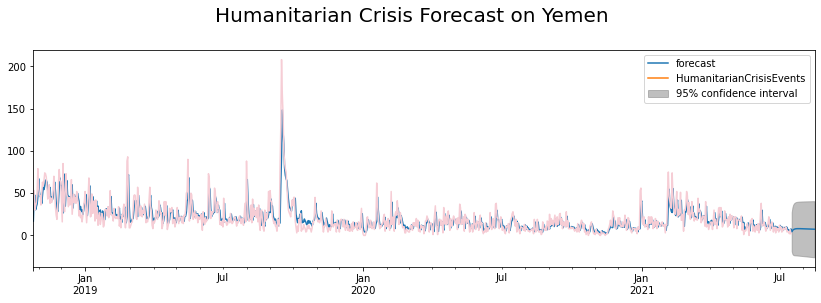

In [1193]:
new_model.predict_with_ci()

In [1121]:
test_ts = new_model.humanitarian_crisis_ts
test_ts

SQLDATE
2018-08-20    0.016461
2018-08-21    0.009569
2018-08-22    0.016461
2018-08-23    0.010381
2018-08-24    0.036810
                ...   
2021-07-12    0.008929
2021-07-13    0.000000
2021-07-14    0.000000
2021-07-15    0.009091
2021-07-16    0.000000
Name: HumanitarianCrisisProportions, Length: 1061, dtype: float64

In [1122]:
end = len(test_pred)
test = new_model.run_best_ARIMA_model()[0]
test_pred = test.predict(start=1, end=end+30)
test_pred

SQLDATE
2018-08-21   -0.000010
2018-08-22    0.002535
2018-08-23   -0.001725
2018-08-24    0.002135
2018-08-25   -0.011851
                ...   
2019-01-31    0.004592
2019-02-01    0.002051
2019-02-02    0.006484
2019-02-03    0.009750
2019-02-04   -0.009272
Length: 168, dtype: float64

Text(0, 0.5, 'new')

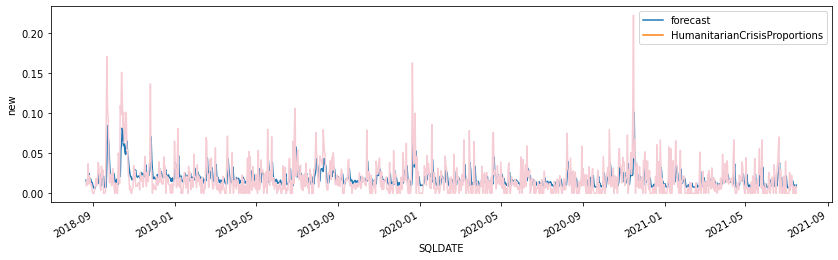

In [1196]:
fig, ax = plt.subplots(figsize=(14,4))
line = test.plot_predict(ax = ax)
plt.gca().get_lines()[1].set_color("#f6cdd5")
plt.ylabel('new')
# ax.label[1].set_color('red')
